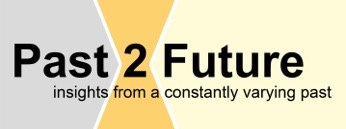

# Variability Figures

## 0. Introduction

This is a notebook that contains/makes some figures for a paper that is being written by Rehfeld et al. Please see the past2future.ipynb for some instructions about notebooks - as this one just gets straight down to business.

### Importing functions
Running the following cell, you are importing python required functions stored in the functions.py file in PMIP4_scripts. 

In [7]:
# press Enter + Shift to run coding cells
from scripts.functions import *
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import iris
from iris import load, Constraint
import iris.quickplot as qplt
import xesmf as xe
%matplotlib inline
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings("ignore")

## Ensemble averaging

This bit of code shold work out what files contain the required variable, so that they can be loaded in for ensemble averaging

In [56]:
def identify_ensemble_members(variable_name,experiment_name):
    datadir="/data/p2f/cvdp_data"
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict

def load_ensemble_mean_diffence_map(variable_name,experiment_A,experiment_B):
    n=0; average=0
    A_dict=ensemble_members_dict(variable_name,experiment_A)
    B_dict=ensemble_members_dict(variable_name,experiment_B)
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-90., 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 179.5, 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
            expt_a=expt_a_file[variable_name]
            expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
            expt_b=expt_b_file[variable_name]
            diff=expt_a-expt_b
            this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True) 
            diff_1x1=this_regridder(diff)
            average=(n*average+diff_1x1)/(n+1)
            n=n+1
    return average

def load_ensemble_mean_map(variable_name,experiment_name):
    n=0; average=0
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-90., 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 179.5, 1.0))})
    for gcm in gcm_dict:
        this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
        this_var=this_file[variable_name]
        this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True) 
        var_1x1=this_regridder(this_var)
        average=(n*average+var_1x1)/(n+1)
        n=n+1
    return average

In [57]:
files_A=identify_ensemble_members("nino34","midHolocene")
print(files_A)
model=extract_model_name(files_A[2])
print(model)

['/data/p2f/cvdp_data/AWI-ESM_midHolocene.cvdp_data.2801-2900.nc', '/data/p2f/cvdp_data/CCSM4_midHolocene.cvdp_data.1000-1300.nc', '/data/p2f/cvdp_data/CNRM-CM5_midHolocene.cvdp_data.1950-2149.nc', '/data/p2f/cvdp_data/FGOALS-g2_midHolocene.cvdp_data.340-1019.nc', '/data/p2f/cvdp_data/GISS-E2-R_midHolocene.cvdp_data.2500-2599.nc', '/data/p2f/cvdp_data/HadGEM2-CC_midHolocene.cvdp_data.1942-1976.nc', '/data/p2f/cvdp_data/HadGEM2-ES_midHolocene.cvdp_data.2061-2161.nc', '/data/p2f/cvdp_data/HadGEM3-GC31_midHolocene.cvdp_data.2250-2349.nc', '/data/p2f/cvdp_data/IPSL-CM5A-LR_midHolocene.cvdp_data.2301-2800.nc', '/data/p2f/cvdp_data/IPSL-CM6A-LR_midHolocene.cvdp_data.1850-2399.nc', '/data/p2f/cvdp_data/KCM1-2-2_midHolocene.cvdp_data.1400-1499.nc', '/data/p2f/cvdp_data/MIROC-ESM_midHolocene.cvdp_data.2330-2429.nc', '/data/p2f/cvdp_data/MPI-ESM-P_midHolocene.cvdp_data.1850-1949.nc', '/data/p2f/cvdp_data/MRI-CGCM3_midHolocene.cvdp_data.1951-2050.nc']
CNRM-CM5


Reuse existing file: bilinear_96x192_180x359.nc
Reuse existing file: bilinear_192x288_180x359.nc
Reuse existing file: bilinear_128x256_180x359.nc
Reuse existing file: bilinear_160x320_180x359.nc
Reuse existing file: bilinear_60x128_180x359.nc
Reuse existing file: bilinear_90x144_180x359.nc
Reuse existing file: bilinear_145x192_180x359.nc
Reuse existing file: bilinear_145x192_180x359.nc
Reuse existing file: bilinear_144x192_180x359.nc
Reuse existing file: bilinear_96x96_180x359.nc
Reuse existing file: bilinear_143x144_180x359.nc
Reuse existing file: bilinear_64x128_180x359.nc
Reuse existing file: bilinear_96x192_180x359.nc
Reuse existing file: bilinear_160x320_180x359.nc
<xarray.DataArray 'tas_spatialmean_ann' (lat: 180, lon: 359)>
array([[-20.133079, -20.133202, -20.130555, ..., -20.137207, -20.133973,
        -20.133987],
       [-33.446051, -33.414569, -33.377238, ..., -33.525916, -33.499332,
        -33.487903],
       [-41.668513, -41.577346, -41.488759, ..., -41.827711, -41.784887

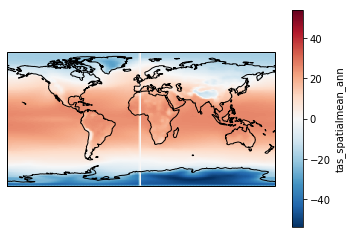

In [59]:
mh_tas=load_ensemble_mean_map("tas_spatialmean_ann","midHolocene")
print(mh_tas)
ax = plt.axes(projection=ccrs.PlateCarree())
mh_tas.plot.pcolormesh(ax=ax);
ax.coastlines();

Reuse existing file: bilinear_96x192_180x359.nc
Reuse existing file: bilinear_192x288_180x359.nc
Reuse existing file: bilinear_128x256_180x359.nc
Reuse existing file: bilinear_160x320_180x359.nc
Reuse existing file: bilinear_90x144_180x359.nc
Reuse existing file: bilinear_145x192_180x359.nc
Reuse existing file: bilinear_144x192_180x359.nc
Reuse existing file: bilinear_96x96_180x359.nc
Reuse existing file: bilinear_143x144_180x359.nc
Reuse existing file: bilinear_64x128_180x359.nc
Reuse existing file: bilinear_96x192_180x359.nc
Reuse existing file: bilinear_160x320_180x359.nc
<xarray.DataArray 'tas_spatialmean_ann' (lat: 180, lon: 359)>
array([[0.034431, 0.033988, 0.037996, ..., 0.026869, 0.029792, 0.031465],
       [0.187489, 0.185962, 0.191142, ..., 0.188445, 0.188715, 0.182206],
       [0.13893 , 0.138185, 0.137537, ..., 0.14185 , 0.140393, 0.139356],
       ...,
       [0.783712, 0.782678, 0.781624, ..., 0.787652, 0.786629, 0.785682],
       [0.806844, 0.806154, 0.805493, ..., 0.808

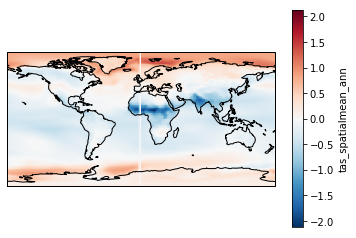

In [60]:
average=load_ensemble_mean_diffence_map("tas_spatialmean_ann","midHolocene","piControl")
print(average)
ax = plt.axes(projection=ccrs.PlateCarree())
average.plot.pcolormesh(ax=ax);
ax.coastlines();

tas_spatialmean_ann / (unknown)     (lat: 180; lon: 359)
     Dimension coordinates:
          lat                           x         -
          lon                           -         x


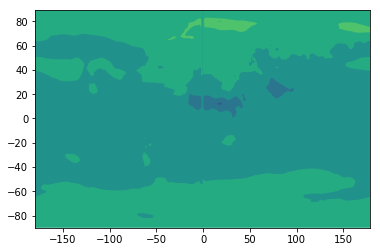

In [50]:
#Can convert this xarray object to an iris cube (but the plot still looks pretty poor)
average_iris=xr.DataArray.to_iris(average)
print(average_iris)
iris.plot.contourf(average_iris,levels=np.arange(-5,5,1),extend='both')

[[-50.347637 -50.34976  -50.35081  ... -50.317616 -50.332375 -50.34215 ]
 [-49.04081  -49.118965 -49.187237 ... -48.665073 -48.814613 -48.93069 ]
 [-48.25056  -48.348587 -48.408638 ... -47.681484 -47.908714 -48.099003]
 ...
 [-17.337662 -17.215439 -17.102314 ... -17.737291 -17.601421 -17.462711]
 [-17.76464  -17.725807 -17.685852 ... -17.896383 -17.849916 -17.806637]
 [-18.100046 -18.095299 -18.090702 ... -18.108234 -18.104961 -18.102001]]
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


ValueError: 'bboxes' cannot be empty

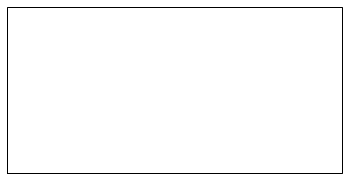

In [51]:
#An attempt at using Iris' native regridding to do this. Fails to plot...
average=varname="tas_spatialmean_ann"
variable_constraint = Constraint(cube_func=(lambda c: c.var_name == varname))
mh_dict=ensemble_members_dict(varname,"midHolocene")
ctl_dict=ensemble_members_dict(varname,"piControl")
grid_target=iris.load(mh_dict.get("AWI-ESM"),variable_constraint)
average=grid_target[0]
print(average.data)
n=0
for gcm in mh_dict:
    if gcm in ctl_dict:
        expt_a=iris.load(mh_dict.get(gcm),variable_constraint)
        expt_b=iris.load(ctl_dict.get(gcm),variable_constraint)
        diff=expt_a[0] - expt_b[0]
        #print('expt_a is %s, expt_b is %s and the difference is %s' % (expt_a[0].data,expt_b[0].data,diff[0].data))
        diff_target=diff.regrid(grid_target[0], iris.analysis.Linear())
        #print(diff_target.data)
        weighted=average.data*n
        average.data=np.add(weighted,diff_target.data)
        average.data=average.data/(n+1)
        #print(average.data)
        n=n+1
        

print(average.data)        
iris.plot.contourf(average,levels=np.arange(-5,5,1),extend='both')

## Scatter Plots 

### Read in data
These scripts make use of the fact that as well as the individual model files there are some mode and ipcc timeseries variables extracted using NCL and sitting in the ~/data directory. This does curtail which plots are possible, but makes them easier and forces me to practice python.

In [67]:
ipcc_filename = 'data/ipcc_region_array.nc'
ipcc_dataset = xr.open_dataset(ipcc_filename)
ipcc=ipcc_dataset.ipcc_region_array
timeseries=ipcc.attrs['timeseries']
expts=ipcc.attrs['expts']
models=ipcc.attrs['models']
print(ipcc)
#Bugger the attribute strings are not easily splittable to convert into searchable dictionaries :-(

<xarray.DataArray 'ipcc_region_array' (models: 33, expts: 8, timeseries: 96, stddev_not_mean: 2)>
array([[[[1.576801, 0.496433],
         ...,
         [7.344153, 0.011412]],

        ...,

        [[     nan,      nan],
         ...,
         [     nan,      nan]]],


       ...,


       [[[     nan,      nan],
         ...,
         [     nan,      nan]],

        ...,

        [[     nan,      nan],
         ...,
         [     nan,      nan]]]], dtype=float32)
Dimensions without coordinates: models, expts, timeseries, stddev_not_mean
Attributes:
    timeseries:  ipcc_ALA_pripcc_ALA_tasipcc_AMZ_pripcc_AMZ_tasipcc_ANT_lnd_p...
    expts:       piControlmidHolocenelgm1pctCO2abrupt4xCO2lig127krcp26rcp85
    models:      AWI-ESMbcc-csm1-1BCC-CSM2-MRBCC-ESM1CCSM4CCSM4-r2CESM2CNRM-C...
